In [2]:
library(Seurat)
library(dplyr)
library(ggplot2)
library(tidyverse)

library(nichenetr)
library(circlize)

In [3]:
setwd("/home/lhc/script/ARDS/neutrophilic_asthma/metadata")

In [4]:
load('saved_Rdata/labeled_ding2_0314.Rdata')
Idents(ding2) <- ding2@meta.data$cell_type

# NicheNet

In [5]:
ligand_target_matrix = readRDS('/data1/lhc/reference/useful_global_tools/NicheNet/ligand_target_matrix.rds')
lr_network = readRDS('/data1/lhc/reference/useful_global_tools/NicheNet/lr_network.rds')
weighted_networks = readRDS('/data1/lhc/reference/useful_global_tools/NicheNet/weighted_networks.rds')

In [6]:
weighted_networks_lr = weighted_networks$lr_sig %>% inner_join(lr_network %>% distinct(from,to), by = c("from","to"))

## Run NicheNet

In [7]:
receiver = "Neutrophil"
expressed_genes_receiver = get_expressed_genes(receiver, ding2, pct = 0.1)
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)]

In [8]:
sender_celltypes = c('T cell','Epithelial cell','Macrophage', 'Neutrophil')

list_expressed_genes_sender = sender_celltypes %>% unique() %>% lapply(get_expressed_genes, ding2, 0.1)
expressed_genes_sender = list_expressed_genes_sender %>% unlist() %>% unique()

In [9]:
seurat_obj_receiver = subset(ding2, idents = receiver)
seurat_obj_receiver = SetIdent(seurat_obj_receiver, value = seurat_obj_receiver[["on_interest"]])

condition_oi = "1"
condition_reference = "0" 
  
DE_table_receiver = FindMarkers(object = seurat_obj_receiver, ident.1 = condition_oi, ident.2 = condition_reference,
                                min.pct = 0.1) %>% rownames_to_column("gene")

In [10]:
geneset_oi = DE_table_receiver %>% filter(p_val_adj <= 0.05 & avg_log2FC >= 0.5) %>% pull(gene)
geneset_oi = geneset_oi %>% .[. %in% rownames(ligand_target_matrix)]
length(geneset_oi)

[1] 296

In [11]:
ligands = lr_network %>% pull(from) %>% unique()
receptors = lr_network %>% pull(to) %>% unique()

expressed_ligands = intersect(ligands,expressed_genes_sender)
expressed_receptors = intersect(receptors,expressed_genes_receiver)

potential_ligands = lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors) %>% pull(from) %>% unique()

In [12]:
ligand_activities = predict_ligand_activities(geneset = geneset_oi, background_expressed_genes = background_expressed_genes,
                                              ligand_target_matrix = ligand_target_matrix, potential_ligands = potential_ligands)

ligand_activities = ligand_activities %>% arrange(-pearson) %>% mutate(rank = rank(desc(pearson)))
ligand_activities %>% head(10)

test_ligand auroc     aupr      aupr_corrected pearson     rank
1  SDK1        0.5615645 0.1296890  0.0227526297  0.060728911  1  
2  APOE        0.5090534 0.1232914  0.0163549594  0.057508617  2  
3  MIF         0.4931018 0.1115853  0.0046488670  0.022870954  3  
4  LTB         0.5175691 0.1144664  0.0075299760  0.020912450  4  
5  SPP1        0.4848014 0.1110828  0.0041463390  0.016457073  5  
6  IL1B        0.4540571 0.1059303 -0.0010061015  0.011838101  6  
7  MMP9        0.4783644 0.1072645  0.0003281006  0.010500047  7  
8  YARS        0.5144018 0.1073842  0.0004477783  0.009226582  8  
9  HLA-DRA     0.5060201 0.1085401  0.0016037012  0.006568811  9  
10 CCL2        0.4740649 0.1041648 -0.0027716474  0.005187540 10

## Visualization

In [13]:
best_upstream_ligands = ligand_activities %>% top_n(20, pearson) %>% arrange(-pearson) %>% pull(test_ligand) %>% unique()

In [14]:
active_ligand_target_links_df = best_upstream_ligands %>%
lapply(get_weighted_ligand_target_links,geneset = geneset_oi, ligand_target_matrix = ligand_target_matrix, n = 200) %>%
bind_rows() %>% drop_na()

active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, 
                                                                 ligand_target_matrix = ligand_target_matrix, cutoff = 0.33)

order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev() 

order_targets = active_ligand_target_links_df$target %>% unique() %>%
intersect(rownames(active_ligand_target_links)) 

rownames(active_ligand_target_links) = rownames(active_ligand_target_links)
colnames(active_ligand_target_links) = colnames(active_ligand_target_links)

vis_ligand_target = active_ligand_target_links[order_targets, order_ligands] %>% t()

Warning message:
“Scaling data with a low number of groups may produce misleading results”


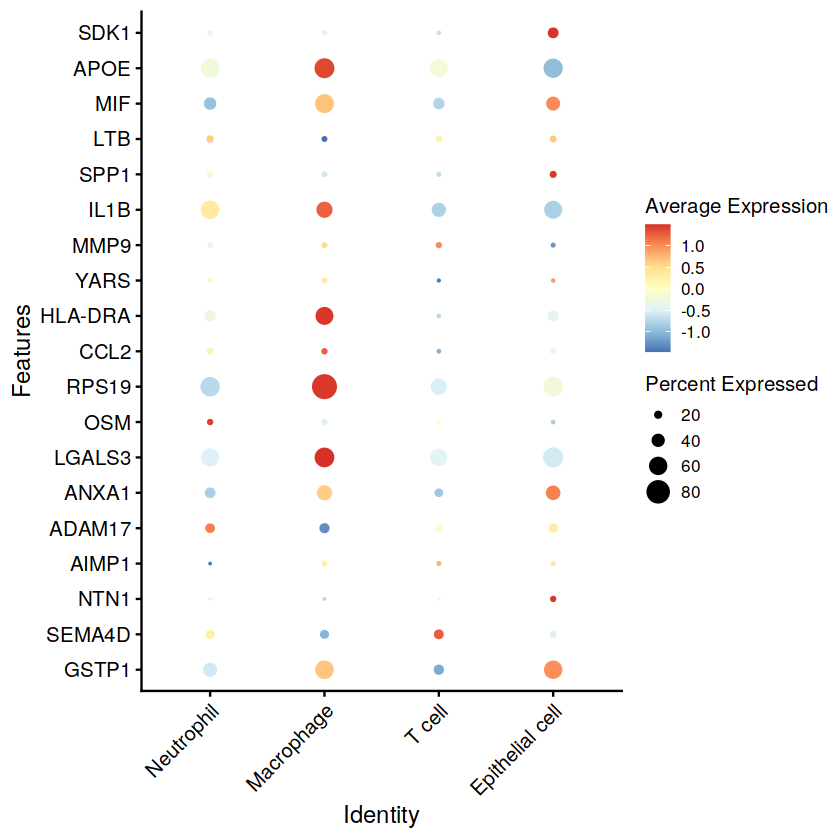

In [15]:
# ligand expression Seurat dotplot
order_ligands_adapted = order_ligands
rotated_dotplot = DotPlot(ding2 %>% subset(cell_type %in% sender_celltypes), features = order_ligands_adapted, 
                          cols = "RdYlBu") + coord_flip() +
theme(legend.text = element_text(size = 10), 
      legend.title = element_text(size = 12), 
      axis.text.x =element_text(size=12, angle = 45, hjust = 1, vjust=1))
rotated_dotplot

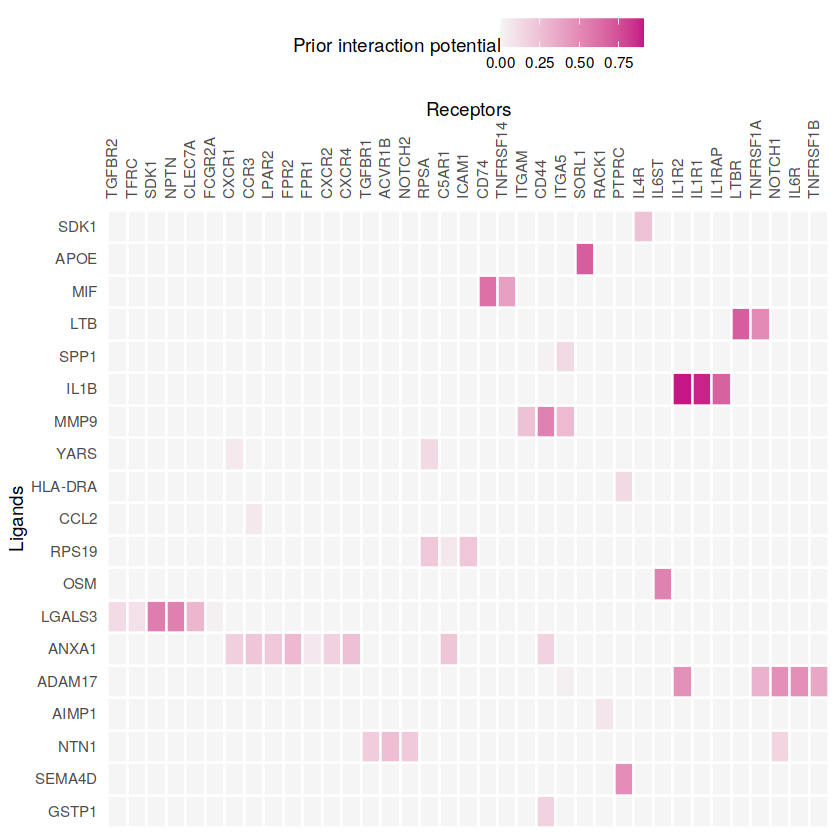

In [16]:
lr_network_top = lr_network %>% filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% distinct(from,to)
best_upstream_receptors = lr_network_top %>% pull(to) %>% unique()

lr_network_top_df_large = weighted_networks_lr %>% filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors)

lr_network_top_df = lr_network_top_df_large %>% spread("from","weight",fill = 0)
lr_network_top_matrix = lr_network_top_df %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to)

dist_receptors = dist(lr_network_top_matrix, method = "binary")
hclust_receptors = hclust(dist_receptors, method = "ward.D2")
order_receptors = hclust_receptors$labels[hclust_receptors$order]
    
dist_ligands = dist(lr_network_top_matrix %>% t(), method = "binary")
hclust_ligands = hclust(dist_ligands, method = "ward.D2")
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order]

order_receptors = order_receptors %>% intersect(rownames(lr_network_top_matrix))
order_ligands_receptor = order_ligands_receptor %>% intersect(colnames(lr_network_top_matrix))

vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, order_ligands_receptor]
rownames(vis_ligand_receptor_network) = order_receptors #%>% make.names()
colnames(vis_ligand_receptor_network) = order_ligands_receptor #%>% make.names()

colnames(vis_ligand_receptor_network)[colnames(vis_ligand_receptor_network) == "HLA.DRA"]  = 'HLA-DRA'
p_ligand_receptor_network = vis_ligand_receptor_network[,order_ligands] %>% t() %>%
make_heatmap_ggplot("Ligands","Receptors", color = "mediumvioletred", x_axis_position = "top",
                    legend_title = "Prior interaction potential")
p_ligand_receptor_network

In [17]:
# ligand activity heatmap
ligand_pearson_matrix = ligand_activities %>% select(pearson) %>%
as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand)

rownames(ligand_pearson_matrix) = rownames(ligand_pearson_matrix) #%>% make.names()
colnames(ligand_pearson_matrix) = colnames(ligand_pearson_matrix) #%>% make.names()

vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson")
p_ligand_pearson = vis_ligand_pearson %>%
make_heatmap_ggplot("Prioritized ligands","Ligand activity", color = "darkorange",legend_position = "top",
                    x_axis_position = "top", legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)") +
theme(legend.text = element_text(size = 9))

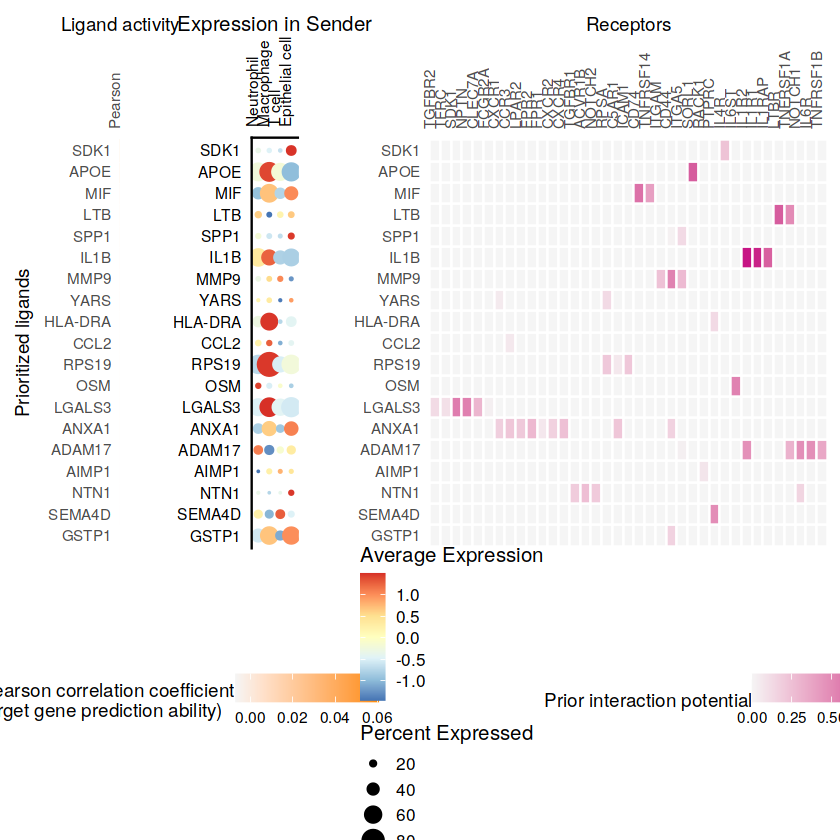

In [18]:
figures_without_legend = cowplot::plot_grid(
  p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()),
  rotated_dotplot + theme(legend.position = "none", axis.ticks = element_blank(), axis.title.x = element_text(size = 12), 
                          axis.text.y = element_text(size = 9), 
                          axis.text.x = element_text(size = 9,  angle = 90, hjust = 0)) +
    ylab("Expression in Sender") + xlab("") + scale_y_discrete(position = "right"),
  p_ligand_receptor_network + theme(legend.position = "none", axis.ticks = element_blank()) + ylab(""),
  align = "hv",
  nrow = 1,
  rel_widths = c(1.5,2,6)
)

legends = cowplot::plot_grid(
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_pearson)),
    ggpubr::as_ggplot(ggpubr::get_legend(rotated_dotplot)),
    ggpubr::as_ggplot(ggpubr::get_legend(p_ligand_receptor_network)),
    nrow = 1,
    align = "h", rel_widths = c(1.5, 1, 1, 1))

combined_plot = cowplot::plot_grid(figures_without_legend, legends, rel_heights = c(10,5), nrow = 2, align = "hv")
combined_plot

In [19]:
active_ligand_target_links_df = best_upstream_ligands %>%
lapply(get_weighted_ligand_target_links,geneset = geneset_oi, 
       ligand_target_matrix = ligand_target_matrix, n = 250) %>% bind_rows()

In [20]:
cutoff_include_all_ligands = active_ligand_target_links_df$weight %>% quantile(0.5, na.rm=TRUE)

active_ligand_target_links_df_circos = active_ligand_target_links_df #%>% filter(weight > cutoff_include_all_ligands)

ligands_to_remove = setdiff(active_ligand_target_links_df$ligand %>% unique(),
                            active_ligand_target_links_df_circos$ligand %>% unique())
targets_to_remove = setdiff(active_ligand_target_links_df$target %>% unique(),
                            active_ligand_target_links_df_circos$target %>% unique())
  
circos_links = active_ligand_target_links_df %>% filter(!target %in% targets_to_remove &!ligand %in% ligands_to_remove)

In [21]:
links_circle = circos_links %>% select(ligand,target, weight)

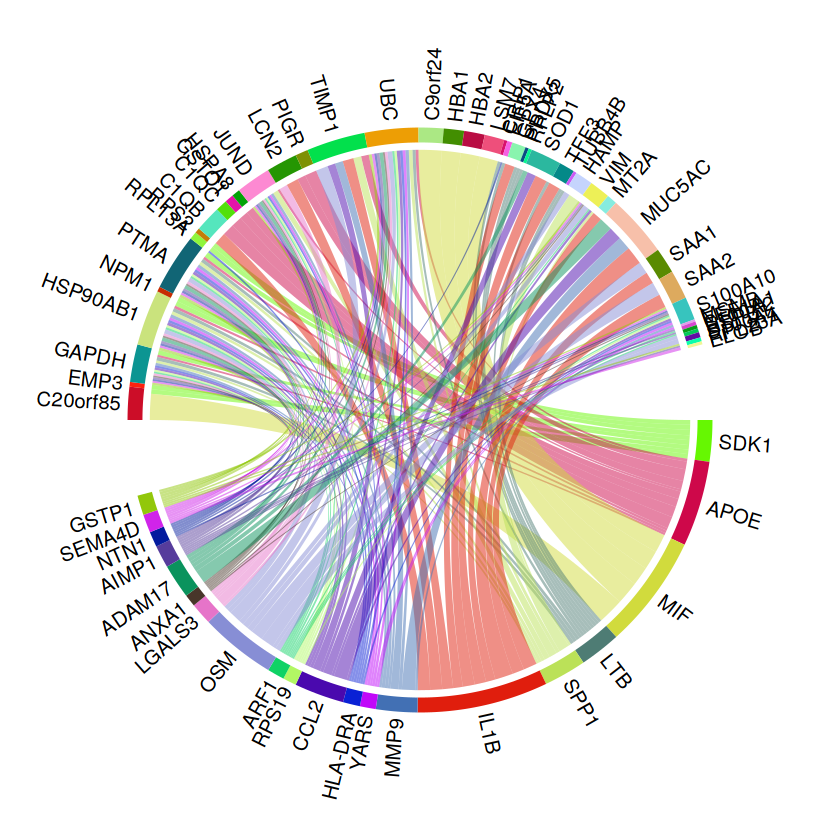

In [22]:
tmp <- links_circle %>% filter(!(target %in% unique(links_circle$ligand))) %>% 
pivot_wider(names_from = target, values_from=weight) %>% as.data.frame 
rownames(tmp) <- tmp$ligand
tmp <- tmp %>% select(-ligand) %>% as.matrix 

circos.par(gap.after = c(rep(0, nrow(tmp)-1),  # 2个5，表示3个行名之间的间隙分别为5个单位
                         15,                   # 表示行名与列名之间的间隙，为15个单位
                         rep(0, ncol(tmp)-1),  # 5个5，表示6个列名之间的间隙分别为5个单位
                         15))
chordDiagram(
  tmp, annotationTrack = "grid", 
  preAllocateTracks = list(
    track.height = max(strwidth(unlist(dimnames(links_circle))))
  )
)
circos.track(
  track.index = 1, panel.fun = function(x, y) {
    circos.text(
      CELL_META$xcenter, CELL_META$ylim[1], 
      CELL_META$sector.index,  facing = "clockwise", 
      niceFacing = TRUE, adj = c(0, 0.5)
    )
  }, bg.border = NA
)